# Problem Statement

Marketing campaigns are typical strategies that banks adopt to enhance their business. To meet their target goals, bank agents target customers through telemarketing phone calls to sell long-term deposits. The contacts made could be both inbound and outbound depending on from which side the calls were initiated. Given the technology, the banks like to understand the likelihood of success of marketing campaigns based on past campaigns data. This helps in optimising their overall cost burden and maximizes the net revenue.

This data is related to such a campaign conducted by a Portuguese retail bank to understand if the marketing campaign will be a success or not. The data spans across 3 past campaigns conducted from May 2008 to November 2010. 

**OBJECTIVE**

* To understand the hidden insights within the data by doing extensive EDA.
* To see what are the relationship of the variables w.r.t the customer has subscribed the term-deposit plans or not.
* Finally to build a predictive model, which predicts the binary outcome for term-deposit subscription. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Description

<ol>
    
### Bank client data:
   <li>age (numeric)</li>
   <li>job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")</li>
   <li>marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)</li>
   <li>education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")</li>
   <li>default: has credit in default? (categorical: "no","yes","unknown")</li>
   <li>housing: has housing loan? (categorical: "no","yes","unknown")</li>
   <li>loan: has personal loan? (categorical: "no","yes","unknown")</li>

### Related with the last contact of the current campaign:
  <li>contact: contact communication type (categorical: "cellular","telephone")</li> 
  <li>month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")</li>
  <li>day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")</li>
  <li>duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.</li>

### Other attributes:
  <li>campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)</li>
  <li>pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)</li>
  <li>previous: number of contacts performed before this campaign and for this client (numeric)</li>
  <li>poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

### Social and Economic context attributes
  <li>emp.var.rate: employment variation rate - quarterly indicator (numeric)</li>
  <li>cons.price.idx: consumer price index - monthly indicator (numeric)</li>     
  <li>cons.conf.idx: consumer confidence index - monthly indicator (numeric)</li>     
  <li>euribor3m: euribor 3 month rate - daily indicator (numeric)</li>
  <li>nr.employed: number of employees - quarterly indicator (numeric)</li>

### Output variable (desired target):
  <li>y - has the client subscribed a term deposit? (binary: "yes","no")</li>
</ol>

In [2]:
# importing libraries for data analysis and linear algebra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import counter class from collections module 
from collections import Counter 

# For performing chi2 test
from scipy.stats import chi2_contingency

# For performing t-test
from scipy.stats import ttest_ind

# For Machine Learning modelling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
bank_df = pd.read_csv('bank-additional-full.csv', sep=';')
print('The dataset has {} observations and {} variables.'.format(bank_df.shape[0], bank_df.shape[1]))

The dataset has 41188 observations and 21 variables.


In [4]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

* It can be seen good we have decent spread in variables in terms of their datatypes. Majority of the variables are categoricals.
* Fortunately, there are no missing values in the dataset. Already in the categorical variables, the missing values are replaced as 'unknown'.

In [6]:
# Checking for duplicates
initial_obs = bank_df.shape[0]
bank_df.drop_duplicates(inplace=True)
final_obs = bank_df.shape[0]
print('Total no. of duplicates removed =',(initial_obs - final_obs))

Total no. of duplicates removed = 12


# Data Exploration

Firstly, we'll split the data into different sections to explore it's characteristics. The sections are the ones mentioned in the data description.

We'll explore every variables by doing univariate and bivariate analysis simultaneously. Doing so, we can not only understand the distributions but also whether the relationship with target variable is significant or not.

In [7]:
# Helper Function to study discrete/categorical variables in the dataset

def categorical_EDA(data,columns):
    for variable in columns:
        plt.figure(figsize=(12,5),dpi=80)
        val_cnt = (data[variable].value_counts()/data.shape[0])*100
        ax = sns.barplot(x=val_cnt.index, y=val_cnt)
        for p in ax.patches:
            ax.annotate('{:.1f}%'.format(p.get_height()/1.0), (p.get_x()+0.35, p.get_height()+0.5))
        print(Counter(data[variable]))
        plt.title('Percentage distribution of {}'.format(variable),fontsize=15)
        plt.xlabel(variable,fontsize=15)
        plt.ylabel('Percentage',fontsize=15)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        plt.show()
        #sns.set(style="whitegrid")

    
# Helper Function to study numerical/continuous variables in the dataset

def numeric_EDA(data,columns,outlier_inc = True):
    for i,var in enumerate(columns):
        new_df = data.copy()
        IQR = new_df[var].quantile(0.75) - new_df[var].quantile(0.25)
        ub = new_df[var].quantile(0.75) + (IQR*1.5)
        lb = new_df[var].quantile(0.25) - (IQR*1.5)

        size = len(columns)
        plt.figure(figsize = (18,4*size))
        if outlier_inc == False:
            new_df = new_df.loc[new_df[var] <= ub]
            new_df = new_df.loc[new_df[var] >= lb]
            IQR_new = new_df[var].quantile(0.75) - new_df[var].quantile(0.25)
            ub_new = new_df[var].quantile(0.75) + (IQR_new*1.5)
            lb_new = new_df[var].quantile(0.25) - (IQR_new*1.5)

            var_summ = ("Distribution of {} without outliers\nMean = {}, Std. Dev. = {}, Median = {}, Min. = {}, Max. = {}\nIQR = {}, Outliers(Low,High) = ({},{})"
                        .format(var,np.mean(new_df[var]),np.std(new_df[var]),np.median(new_df[var]),np.min(new_df[var]),np.max(new_df[var]),IQR_new,lb_new,ub_new))
            
            plt.subplot(i+1,2,1)
            sns.distplot(new_df[var], bins=30)
            plt.subplot(i+1,2,2)
            sns.boxplot(var, data = new_df)
            plt.suptitle(var_summ)
            sns.despine()
            plt.show()

        else:
            var_summ = ("Distribution of {} with outliers\nMean = {}, Std. Dev. = {}, Median = {}, Min. = {}, Max. = {}\nIQR = {}, Outliers(Low,High) = ({},{})"
                        .format(var,np.mean(new_df[var]),np.std(new_df[var]),np.median(new_df[var]),np.min(new_df[var]),np.max(new_df[var]),IQR,lb,ub))

            plt.subplot(i+1,2,1)
            sns.distplot(new_df[var], bins=30)
            plt.subplot(i+1,2,2)
            sns.boxplot(var, data = new_df)
            plt.suptitle(var_summ)
            sns.despine()
            plt.show()
    
    

In [8]:
# Helper function for numerical-categorical bivariate analysis

def bivariate_num_categ(data,cont,categ):
    df = data.copy()
    # split the data into two groups
    S1 = df.loc[df[categ] == df[categ].unique()[0],cont]
    S2 = df.loc[df[categ] == df[categ].unique()[1],cont]
    
    # Performing the t-test
    t_stat, p_value = ttest_ind(S1,S2,equal_var=False)
    
    # Checking if the difference is significant
    if p_value < 0.05:
        sig = True
    else:
        sig = False
        
    # visualizing the bivariate graph
    plt.figure(figsize = (12,5))
    sns.boxplot(y=cont, x=categ, data = df)
    plt.title("Relationship between {} and {}\nt-statistic = {}, p-value = {}\ndifference is significant = {}"
              .format(cont,categ,t_stat,p_value,sig), fontsize=12)

    
# Helper function for categorical-categorical bivariate analysis

def bivariate_categ_categ(data,categ,tar):
    df = data.copy()
    chi_obs = list()
    tab = pd.crosstab(df[tar], df[categ])
    for i in range(len(tab.index)):
        chi_obs.append(tab.iloc[i].values)
    chi_obs = np.array(chi_obs)
    
    # Performing the chi-square test
    chi_stat, p_value, dof, exp_obs = chi2_contingency(chi_obs)
    
    # Checking if the difference is signifiant
    if p_value < 0.05:
        sig = True
    else:
        sig = False

    # Visualizing the bivariate graph
    plt.figure(figsize = (15,5))
    ax = sns.countplot(x=categ, hue=tar, data=df)
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/(len(df[tar])*1.000)), (p.get_x()+0.1, p.get_height()+0.5))

    print(tab)
    plt.title("Relationship between {} and {}\nchi2-statistic = {}, p-value = {}\ndifference is significant = {}"
      .format(categ,tar,chi_stat,p_value,sig), fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.xlabel(categ,fontsize=15)
    plt.ylabel('Total Count',fontsize=15)
    plt.show()
    

### `Target Variable Exploration`

In [9]:
bank_df.rename(columns={"y":"term_deposit"},inplace=True)

In [10]:
len(bank_df["term_deposit"])*1.0

41176.0

Counter({'no': 36537, 'yes': 4639})


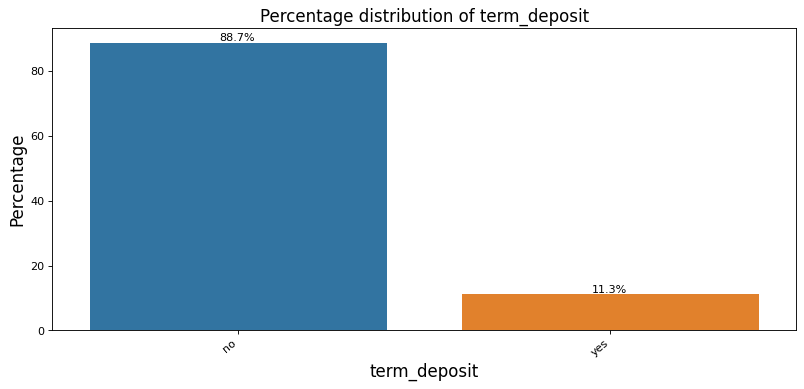

In [11]:
categorical_EDA(bank_df,['term_deposit'])

In this binary classification problem, our target variable is imbalanced. We can clearly see that only **11.3%** of people in our sample have subscribed to bank's term deposit. While **88.7%** of people in our sample haven't subscribed to bank's term deposit.

This is pretty obvious as few people respond positively to any such marketing campaigns. Also, here we are interested to predict people who'll subscribe the term deposit. Therefore during modelling phase it's important that we take care of this class imbalance using oversampling technique.

### Bank client data

### `Age`

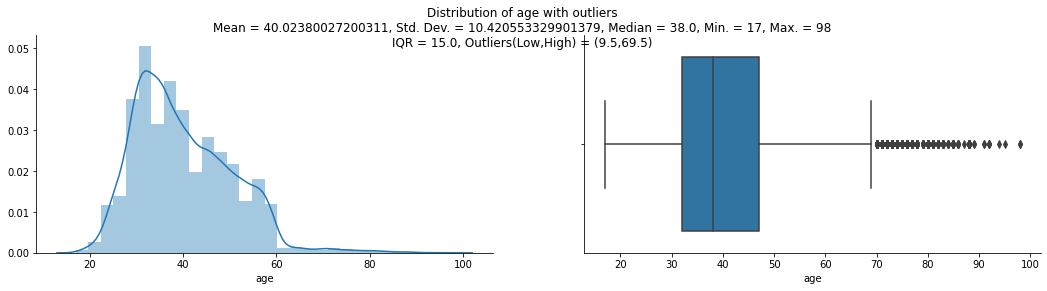

In [12]:
numeric_EDA(bank_df,['age'])

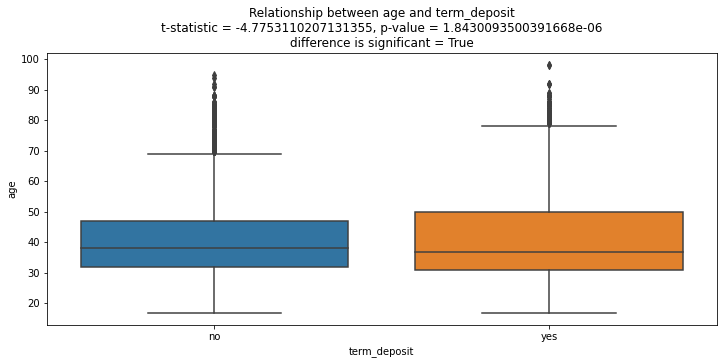

In [13]:
bivariate_num_categ(bank_df,'age','term_deposit')

The *age* variable has a moderate left skewed distribution as seen from above graphs. Most of the customers are in 20-60 years age with median age between 38-40 years. Customers who are >= 70 years can be seen as outliers, but there prescence has a very minimal effect on the central tendency of the variable. 

Also we can see from the bivariate analysis, the p-value < 0.05 which indicates *age* variable has a significant relationship with our target variable *term_deposit*.

### `Job`

Counter({'admin.': 10419, 'blue-collar': 9253, 'technician': 6739, 'services': 3967, 'management': 2924, 'retired': 1718, 'entrepreneur': 1456, 'self-employed': 1421, 'housemaid': 1060, 'unemployed': 1014, 'student': 875, 'unknown': 330})


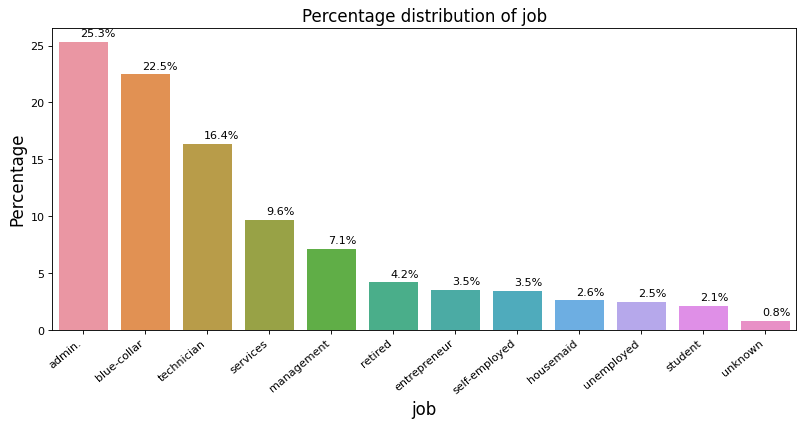

In [14]:
categorical_EDA(bank_df,['job'])

job           admin.  blue-collar  ...  unemployed  unknown
term_deposit                       ...                     
no              9068         8615  ...         870      293
yes             1351          638  ...         144       37

[2 rows x 12 columns]


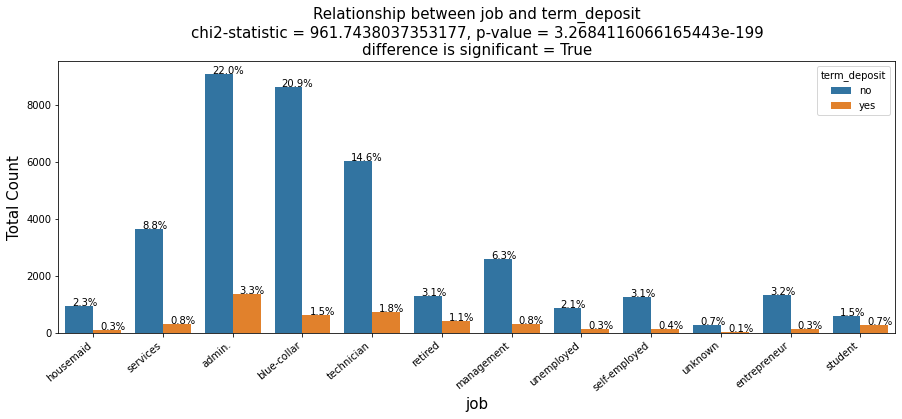

In [15]:
bivariate_categ_categ(bank_df,'job','term_deposit')

**Observations:**
* A good distribution of customers are their in our sample based on their employment type. Looking at *job* variable, We can see majority of the customers are working as **admin,blue-collar,technician**.
* As we move from lower to higher paid salaries, we have a gradual decline in the number of customers in our sample.
* Same pattern could be observed when we observe the distribution w.r.t both the classes in our target variable.
* Most importantly, there is a significant relationship between **job** and **term_deposit** as the p-value < 0.05.

### `Marital`

Counter({'married': 24921, 'single': 11564, 'divorced': 4611, 'unknown': 80})


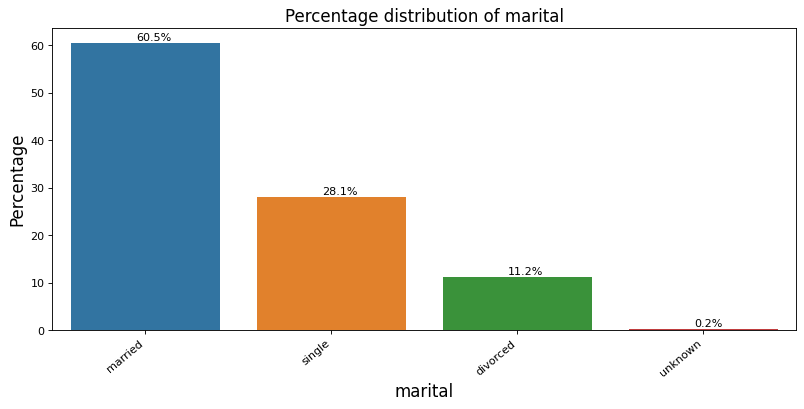

marital       divorced  married  single  unknown
term_deposit                                    
no                4135    22390    9944       68
yes                476     2531    1620       12


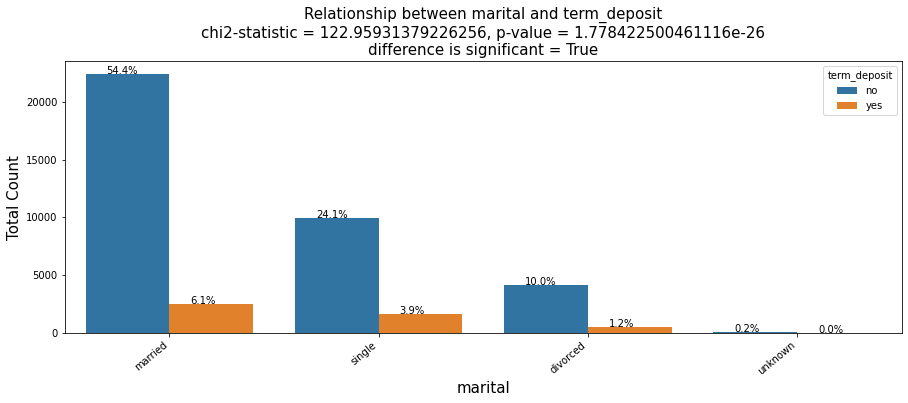

In [16]:
categorical_EDA(bank_df,['marital'])
bivariate_categ_categ(bank_df,'marital','term_deposit')

**Observations:**
* In our analysis for *marital* variable, We can see majority of the customers are working as **married** followed by **single** people.
* Here also there is a significant relationship with our target variable,**term_deposit** as the p-value < 0.05.

### `Education`

Counter({'university.degree': 12164, 'high.school': 9512, 'basic.9y': 6045, 'professional.course': 5240, 'basic.4y': 4176, 'basic.6y': 2291, 'unknown': 1730, 'illiterate': 18})


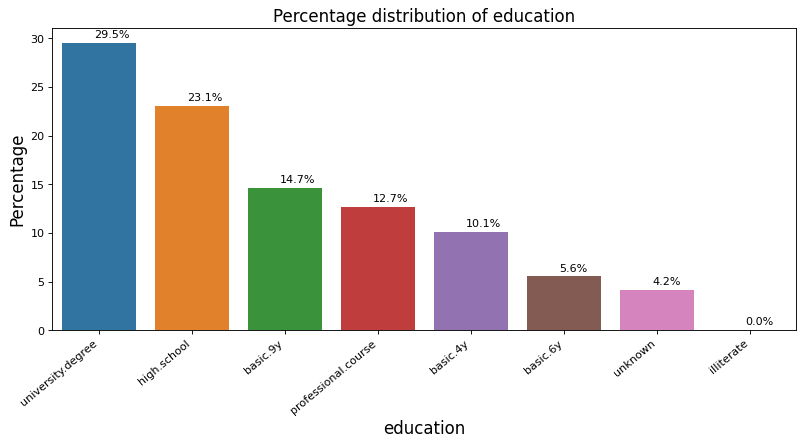

education     basic.4y  basic.6y  ...  university.degree  unknown
term_deposit                      ...                            
no                3748      2103  ...              10495     1479
yes                428       188  ...               1669      251

[2 rows x 8 columns]


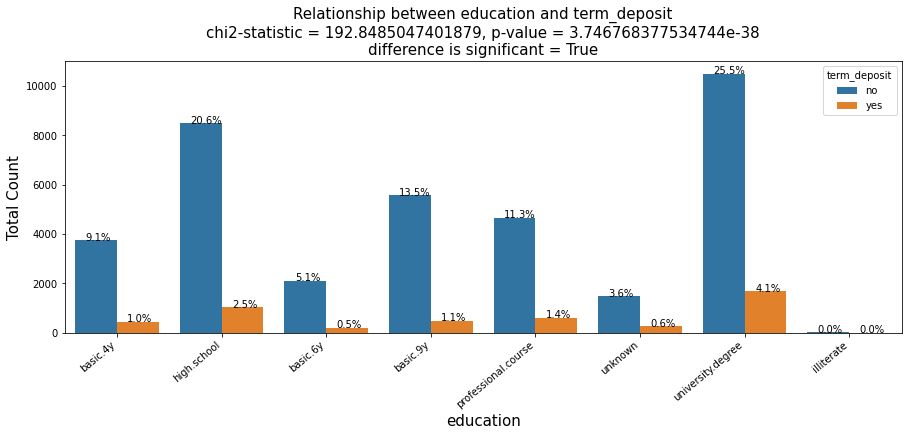

In [17]:
categorical_EDA(bank_df,['education'])
bivariate_categ_categ(bank_df,'education','term_deposit')

**Observations:**
* In our analysis for *eduaction* variable, We can see majority of the customers have completed their schooling. It is evident as majority of them have at least finished their **high school**.
* Customers who have at least finished their high school, are morely to subcribe the term deposit than compared to others.
* Here also there is a significant relationship with our target variable,**term_deposit** as the p-value < 0.05.

### `Default`

Counter({'no': 32577, 'unknown': 8596, 'yes': 3})


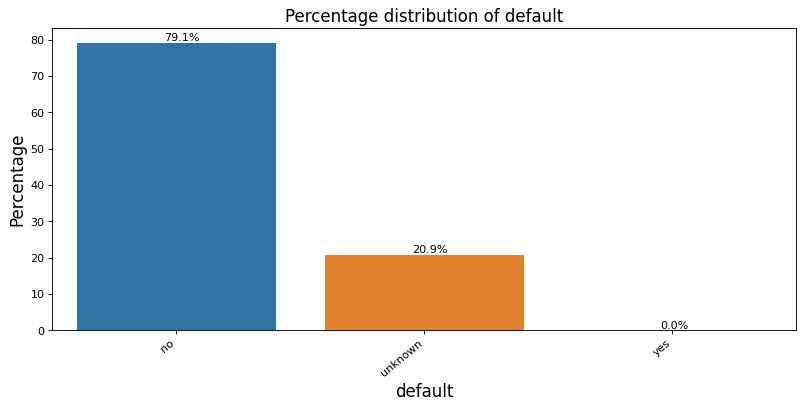

default          no  unknown  yes
term_deposit                     
no            28381     8153    3
yes            4196      443    0


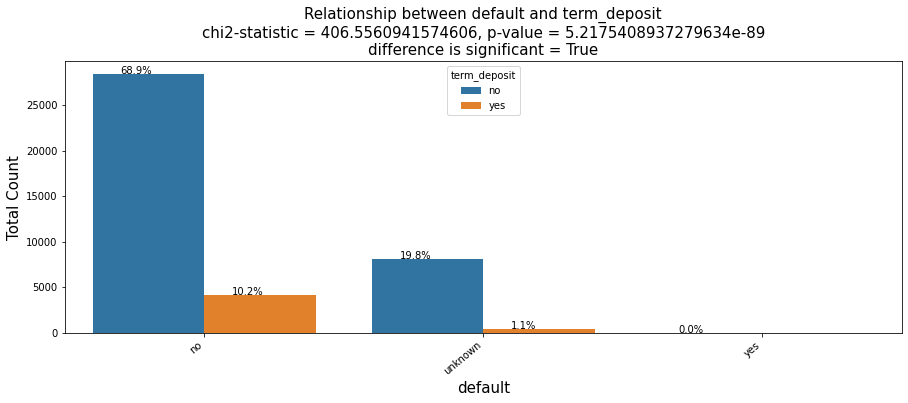

In [18]:
categorical_EDA(bank_df,['default'])
bivariate_categ_categ(bank_df,'default','term_deposit')

**Observations:**
* In our analysis for *default* variable, majority of the customers haven't defaulted. Only 3 customers are there in our sample who have defaulted, while the rest status is unknown.
* Also there is a significant relationship with our target variable,**term_deposit** as the p-value < 0.05.

### `Housing`

Counter({'yes': 21571, 'no': 18615, 'unknown': 990})


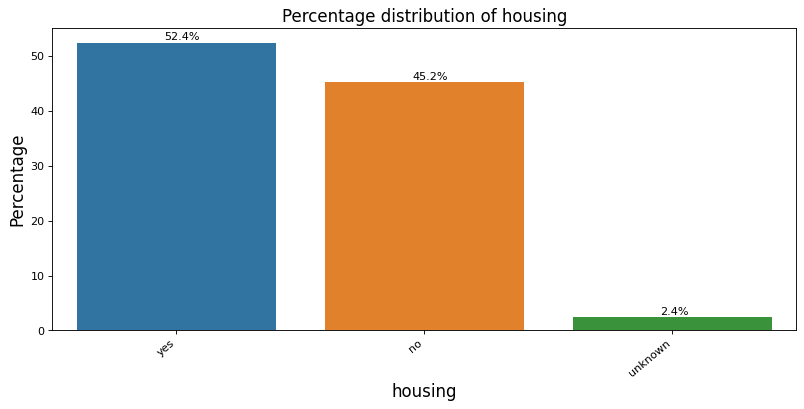

housing          no  unknown    yes
term_deposit                       
no            16590      883  19064
yes            2025      107   2507


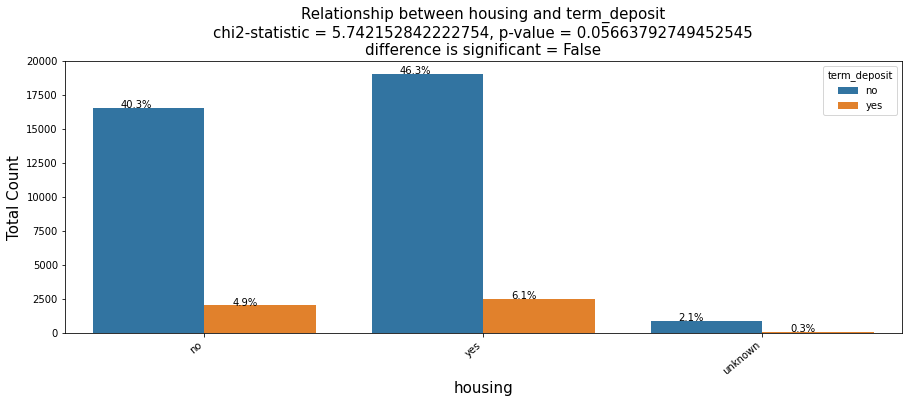

In [19]:
categorical_EDA(bank_df,['housing'])
bivariate_categ_categ(bank_df,'housing','term_deposit')

We can observe the ratio of customers with house over customers without house is **1.1:1**. Moreover p-value > 0.05, which shows there is no significant relationship w.r.t to **term_deposit**. Therefore, we'll exclude this variable from our model.

### `Loan`

Counter({'no': 33938, 'yes': 6248, 'unknown': 990})


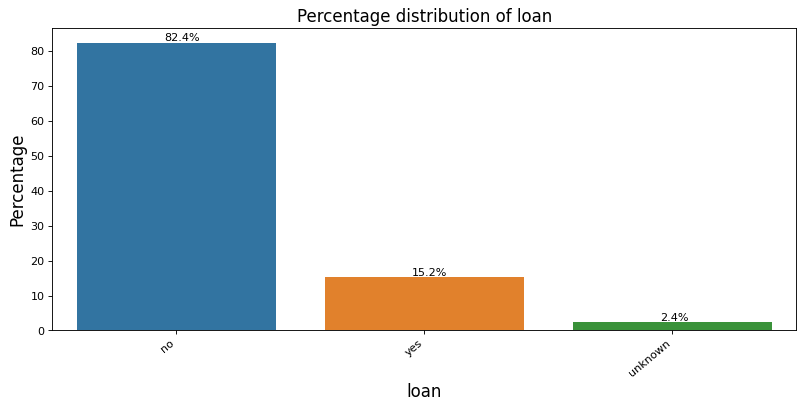

loan             no  unknown   yes
term_deposit                      
no            30089      883  5565
yes            3849      107   683


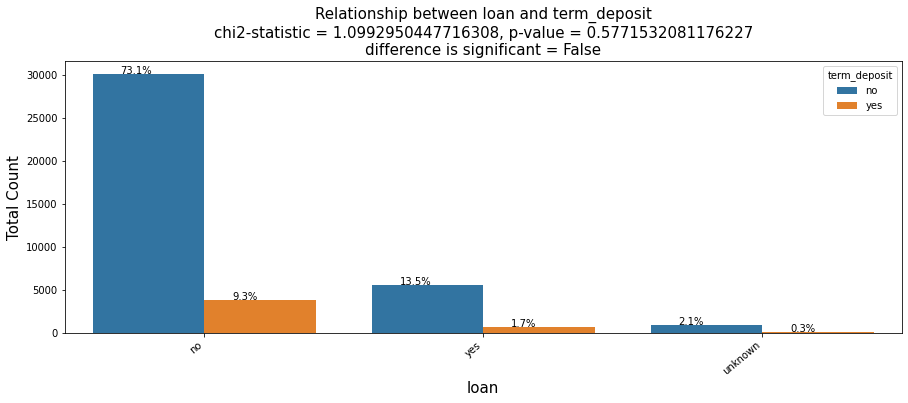

In [20]:
categorical_EDA(bank_df,['loan'])
bivariate_categ_categ(bank_df,'loan','term_deposit')

Majority of customers(82.4%) in our sample don't have a loan as can be seen from the graph. Moreover it has no significant relationship with term_deposit. This variable will also be excluded from our model.

### Information related to last contact

### `Contact`

Counter({'cellular': 26135, 'telephone': 15041})


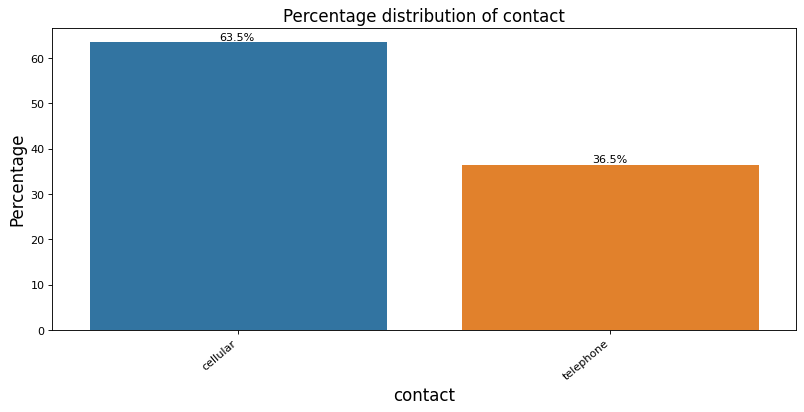

contact       cellular  telephone
term_deposit                     
no               22283      14254
yes               3852        787


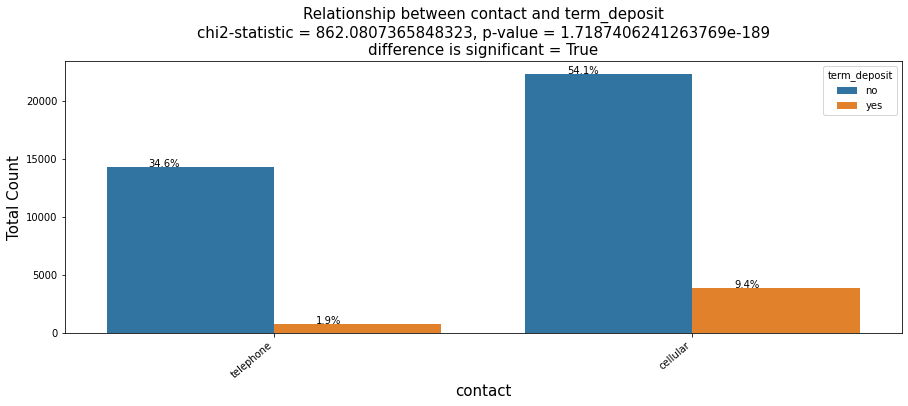

In [21]:
categorical_EDA(bank_df,['contact'])
bivariate_categ_categ(bank_df,'contact','term_deposit')

**Observations:**
We can clearly see most of the customers were contacted in their **cellular** phone number and they are the ones who are more likely to subscribe the term deposit plan. It has significant relationship with **term_deposit** as p-value < 0.05.

### `Day of Week`

Counter({'thu': 8618, 'mon': 8512, 'wed': 8134, 'tue': 8086, 'fri': 7826})


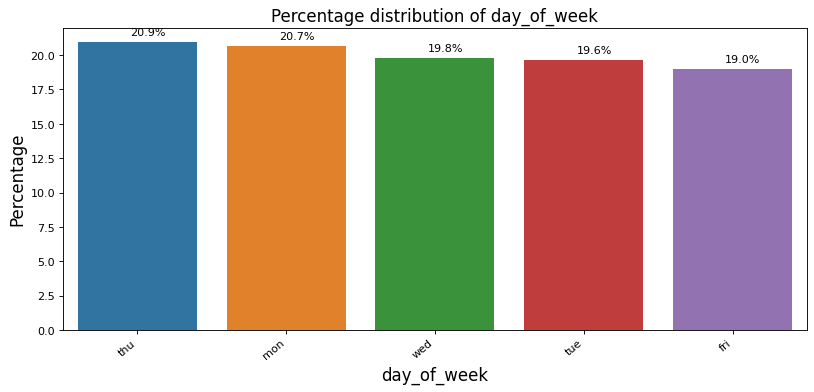

day_of_week    fri   mon   thu   tue   wed
term_deposit                              
no            6980  7665  7574  7133  7185
yes            846   847  1044   953   949


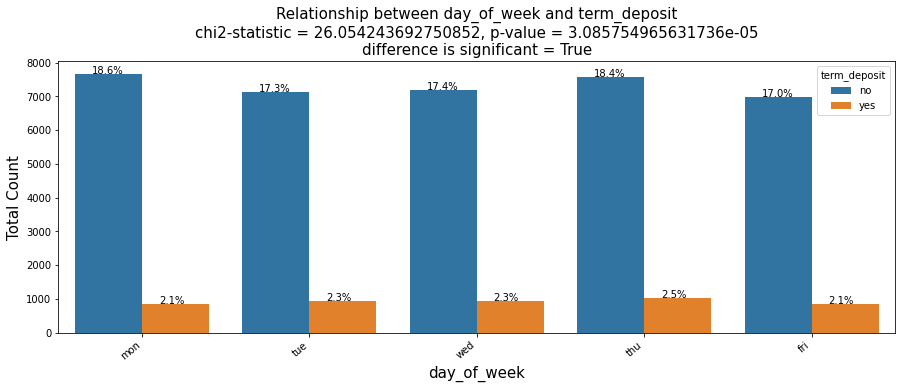

In [22]:
categorical_EDA(bank_df,['day_of_week'])
bivariate_categ_categ(bank_df,'day_of_week','term_deposit')

**Observations:**
* From above graphs, we can see almost equal proportion of contacts were made across 5 working days of a week. So, at first glance we may infer that *day_of_week* has no effect on our target variable.
* But, we can see p-value < 0.05 which rather suggests that it has a significant relationship with *term_deposit*.

### `Month`

Counter({'may': 13767, 'jul': 7169, 'aug': 6176, 'jun': 5318, 'nov': 4100, 'apr': 2631, 'oct': 717, 'sep': 570, 'mar': 546, 'dec': 182})


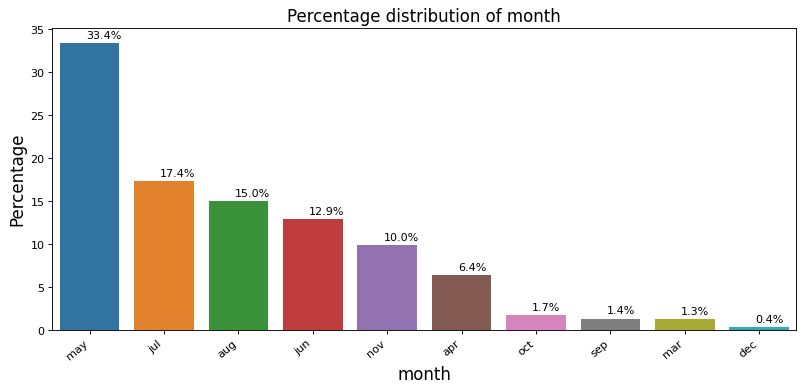

month          apr   aug  dec   jul   jun  mar    may   nov  oct  sep
term_deposit                                                         
no            2092  5521   93  6521  4759  270  12881  3684  402  314
yes            539   655   89   648   559  276    886   416  315  256


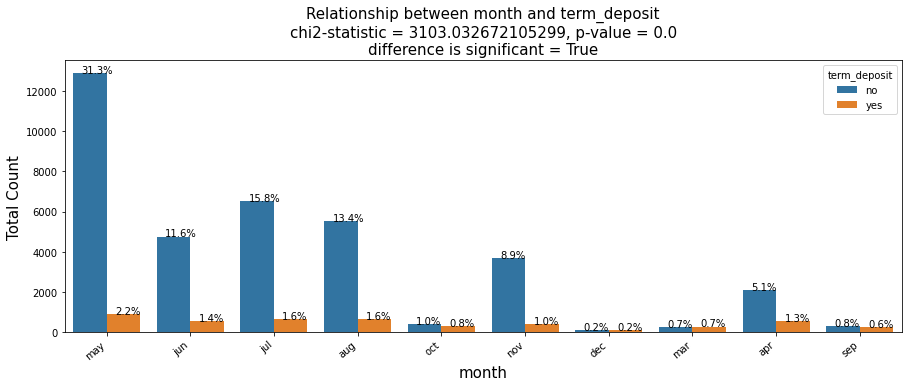

In [23]:
categorical_EDA(bank_df,['month'])
bivariate_categ_categ(bank_df,'month','term_deposit')

**Observations:**
* In our analysis of *month* variable, we can see the campaign was done from **Mar-Dec**. 
* It can be seen in **May**, large no. of calls were made to the customers. It may be due to some targets and incentive goals set for the agents by the bank.
* From the bivariate analysis, we can see p-value < 0.05 which indicates that it has a significant relationship with **term_deposit**.

### `Duration`

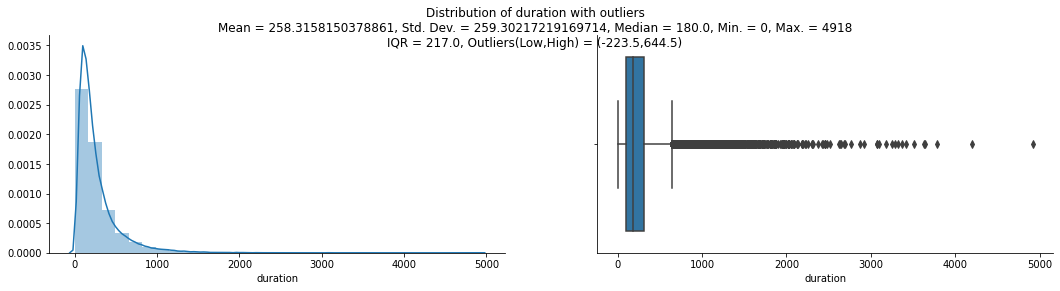

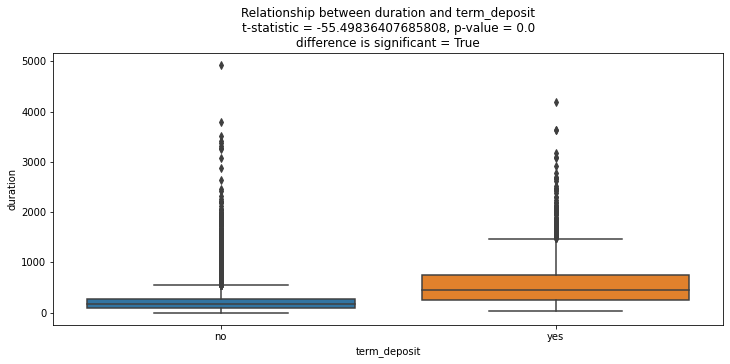

In [24]:
numeric_EDA(bank_df,['duration'])
bivariate_num_categ(bank_df,'duration','term_deposit')

**Observations:**
* In our analysis of *duration* variable, we can see it has high **left skewed** distribution with a long right tail. It is understood intuitively that most of the customers don't interact long with bank agents if they are not interested in term deposit plan.
* Most of calls last anywhere between **102.0 - 317.0 seconds** with an average call duration of **258 seconds**.
* Some anomalous points were observed like there is a particular which lasted for **1 hour 22 minutes**.
* Customers who have subscribed to term deposit have a higher median call duration of **7.48 mins.**. Compared to that, customers who haven't subscribed the term deposit have median call duration of **2.73 mins.**

**Note**: 
As mentioned earlier in data description. using this variable will anyways give best results as target variable is highly dependent on this. Therefore to have a realistic model, we will not use this variable as duration of a call is not known prior to a call is made.

### Other Information

### `Campaign`

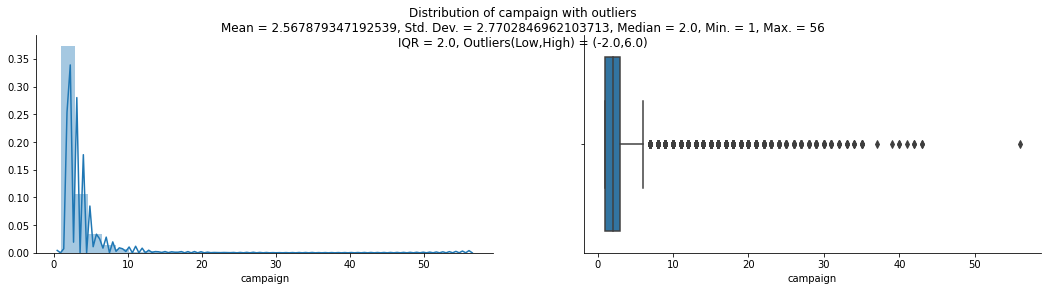

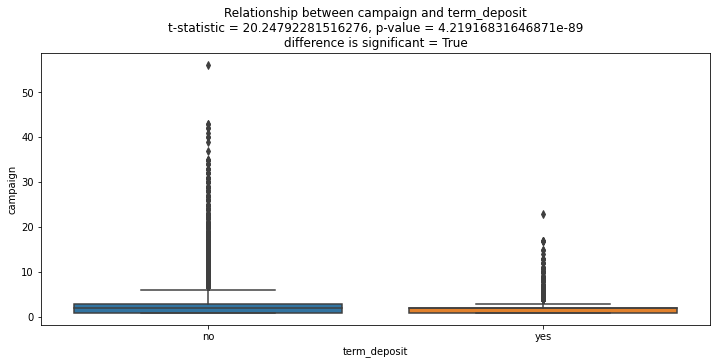

In [25]:
numeric_EDA(bank_df,['campaign'])
bivariate_num_categ(bank_df,'campaign','term_deposit')

**Observations:**
* In our analysis of *campaign* variable, we can see that majority of the customers have been **less than equals to 6 calls**.
* We can see the number of contacts that are greater than 6, are seen as outliers here. To mitigate this problem, we can create bins for this variables as this has only **42 unique** values. This we can handle in the feauture engineering section.
* This variable has significant relationship with **term_deposit** as seen from t-test.

### `pdays`

Counter({999: 39661, 3: 439, 6: 412, 4: 118, 9: 64, 2: 61, 7: 60, 12: 58, 10: 52, 5: 46, 13: 36, 11: 28, 1: 26, 15: 24, 14: 20, 8: 18, 0: 15, 16: 11, 17: 8, 18: 7, 22: 3, 19: 3, 21: 2, 25: 1, 26: 1, 27: 1, 20: 1})


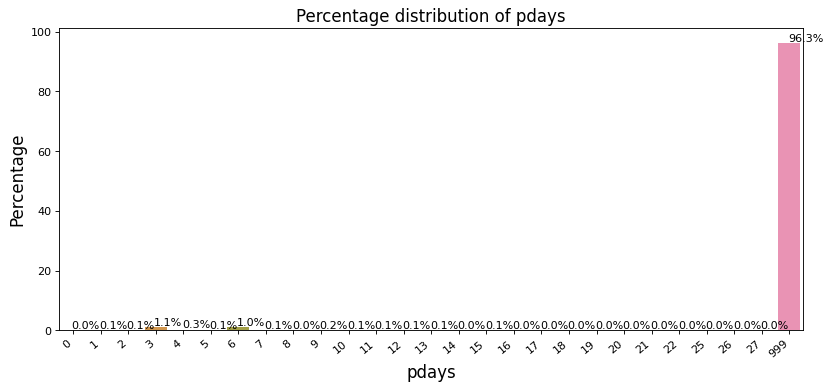

In [26]:
categorical_EDA(bank_df,['pdays'])

We can see, in our sample almost **96.3%** customers are contacted for first time. Rest **3.7%** customers have contacted previously.
In feature engineering section, we'll convert this into a binary feature as that makes more sense here.

### `previous`

Counter({0: 35551, 1: 4561, 2: 754, 3: 216, 4: 70, 5: 18, 6: 5, 7: 1})


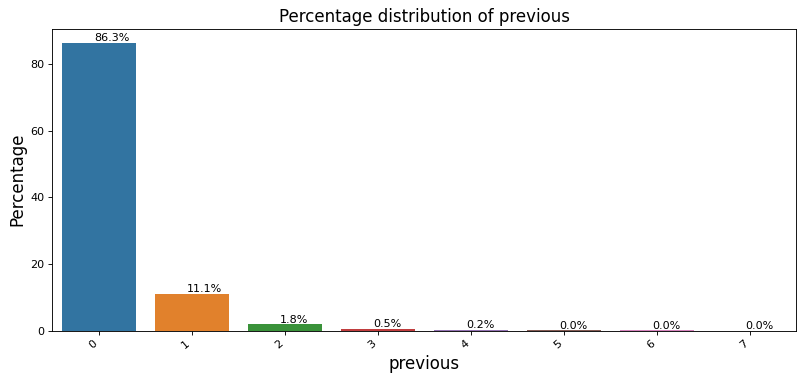

In [27]:
categorical_EDA(bank_df,['previous'])

**Observations:**
* In our analysis of *previous* variable, we can see majority of customers (**86.3%**) were not contacted in previous campaign. It is understood as majority of the customers are contacted for first time in this campaign.
* Moreover very few customers have been contacted for more than **4 times** in previous campaign. To mitigate this, we can club customers to `previous = 5`, for those who have `previous >= 5`.


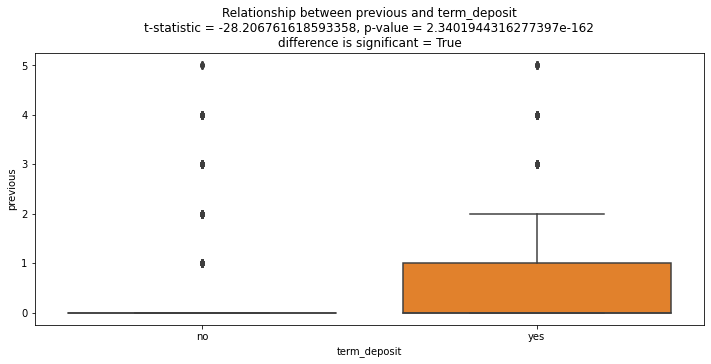

In [28]:
bank_df.loc[bank_df['previous'] >= 5,'previous'] = 5
bivariate_num_categ(bank_df,'previous','term_deposit')

### `poutcome`

Counter({'nonexistent': 35551, 'failure': 4252, 'success': 1373})


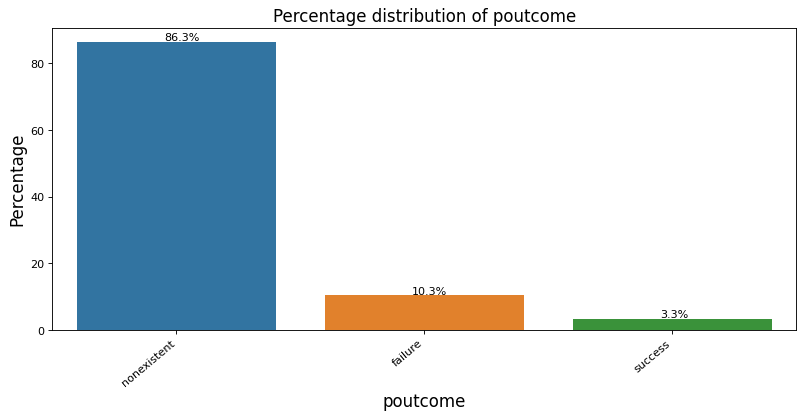

poutcome      failure  nonexistent  success
term_deposit                               
no               3647        32411      479
yes               605         3140      894


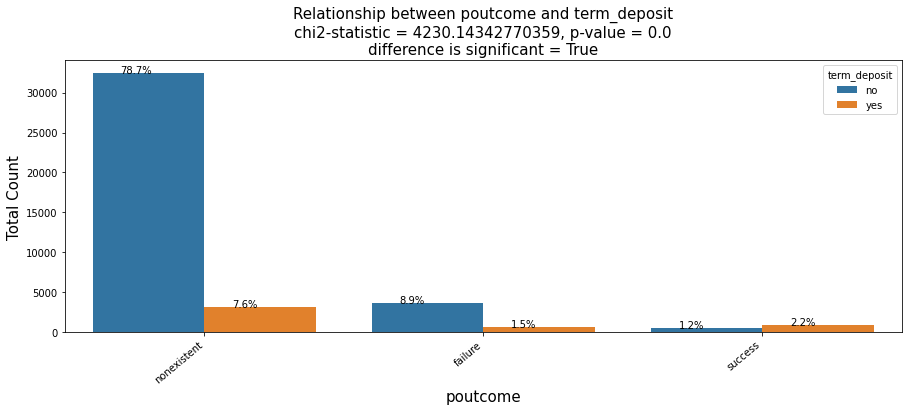

In [29]:
categorical_EDA(bank_df,['poutcome'])
bivariate_categ_categ(bank_df,'poutcome','term_deposit')

**Observations:**
* In our analysis of *poutcome* variable, we can see 3 specific categories related to outcomes of previous campaigns.
* Campaigns which were **success** in past have a higher conversion rate ratio **1.86:1** compared to other two campaigns.
* This variable has a significant relationship with *term_deposit* as p-value < 0.05.


### Socio - Economic Attributes

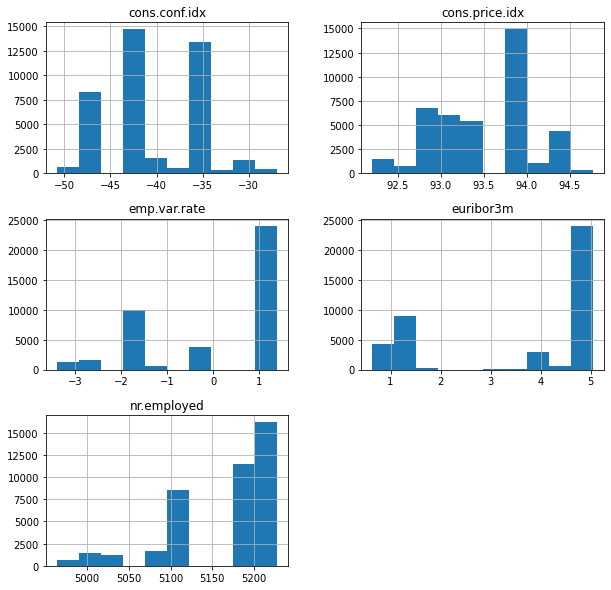

In [30]:
SE_vars = ['emp.var.rate','cons.price.idx','cons.conf.idx','nr.employed','euribor3m']
bank_df[SE_vars].hist(figsize=(10,10))
plt.show()

### Handling missing values in `job`, `education` and `marital`

* To impute the 'unknown' class for *job* and *education*, we'll do the conditional mode imputation for both the classes.
* To do so we'll use the cross-tabulation between these two variables.
* For *marital*, we'll directly do the mode imputation.
* For *default*, we'll not do any imputation as more than 70% haven't defaulted and rest of the values are 'unknown'.
* For *housing* and *loan*, we'll not do any imputation as these variables will not be used in our model.

In [31]:
miss_data = pd.crosstab(bank_df['job'],bank_df['education'])
miss_data

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,77,151,499,3329,1,363,5750,249
blue-collar,2318,1425,3623,878,8,453,94,454
entrepreneur,137,71,210,234,2,135,610,57
housemaid,474,77,94,174,1,59,139,42
management,100,85,166,298,0,89,2063,123
retired,597,75,145,276,3,241,284,97
self-employed,93,25,220,118,3,168,765,29
services,132,226,388,2680,0,218,173,150
student,26,13,99,357,0,43,170,167


In [32]:
df_miss = bank_df.copy()

# Missing value imputation for Education

for job in miss_data.index[:-1]:
    mode_edu = df_miss.loc[df_miss['job']==job,'education'].value_counts().index[0]
    df_miss.loc[(df_miss['job']==job) & (df_miss['education']=='unknown'),'education'] = mode_edu


# Missing value imputation for Job

edu_class = list(miss_data.columns)
edu_class.remove('illiterate')
edu_class.remove('unknown')


for edu in edu_class:
    mode_job = df_miss.loc[df_miss['education']==edu,'job'].value_counts().index[0]
    df_miss.loc[(df_miss['education']==edu) & (df_miss['job']=='unknown'),'job'] = mode_job

df_miss.loc[df_miss['job']=='unknown','job'] = df_miss['job'].value_counts().index[0]
df_miss.loc[df_miss['education']=='unknown','education'] = df_miss['education'].value_counts().index[0]


In [33]:
# Missing value imputation for Marital

df_miss.loc[df_miss['marital']=='unknown','marital'] = df_miss['marital'].value_counts().index[0]

# Feature Engineering

* For *campaign* variable, we had seen that majority of the customers were contacted between 1-6 times. For rest, we can see they are sparsely distributed. Therefore creating bins out of this variable, will give a better picture about the overall distribution.
* Creating bins for this variable will negate the effect of outliers in the model.

In [34]:
df_miss['campaign'].describe()

count    41176.000000
mean         2.567879
std          2.770318
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

In [35]:
df = df_miss.copy()

# Define bins based on statistics
campaign_bins = [0, 2, 10, 20, 60]
campaign_labels = ['1-2', '3-10', '11-20', '>20']

# Map to bins using pd.cut()
df['campaign_bin'] = pd.cut(df['campaign'], bins = campaign_bins, labels = campaign_labels)
(df['campaign_bin'].value_counts()/df.shape[0])*100

1-2      68.491354
3-10     29.398193
11-20     1.729163
>20       0.381290
Name: campaign_bin, dtype: float64

**pdays**
* From *pdays* variable, we had seen during that 96.3% are new customers while rest are with the bank from earlier campaigns. 
* Therefore we can convert this variable into binary categorical variable instead.

In [36]:
df['pdays'] = df['pdays'].map(lambda x: 1 if x == 999 else 0)

In [37]:
df['pdays'].value_counts()

1    39661
0     1515
Name: pdays, dtype: int64

In [38]:
final_df = df.copy()

final_df['term_deposit'] = final_df['term_deposit'].map(lambda x: 1 if x == 'yes' else 0)

# Model building and Evaluation

In [39]:
final_df.drop(['duration','housing','loan','campaign'], axis = 1, inplace=True)

In [40]:
#campaign_encoded = pd.get_dummies(final_df['campaign_bin'], prefix = 'campaign', prefix_sep='_dummy_')
#campaign_encoded = campaign_encoded.iloc[:,0:3]
#others_encoded = pd.get_dummies(final_df.drop('campaign_bin',axis=1), prefix_sep='_dummy_', drop_first=True)

#final_df_encoded = pd.concat([others_encoded,campaign_encoded], axis=1)
final_df_encoded = pd.get_dummies(final_df, prefix_sep='_dummy_', drop_first=True)
final_df_encoded.iloc[0]

age                                      56.000
pdays                                     1.000
previous                                  0.000
emp.var.rate                              1.100
cons.price.idx                           93.994
cons.conf.idx                           -36.400
euribor3m                                 4.857
nr.employed                            5191.000
term_deposit                              0.000
job_dummy_blue-collar                     0.000
job_dummy_entrepreneur                    0.000
job_dummy_housemaid                       1.000
job_dummy_management                      0.000
job_dummy_retired                         0.000
job_dummy_self-employed                   0.000
job_dummy_services                        0.000
job_dummy_student                         0.000
job_dummy_technician                      0.000
job_dummy_unemployed                      0.000
marital_dummy_married                     1.000
marital_dummy_single                    

In [41]:
final_df_encoded.shape

(41176, 48)

In [42]:
X = final_df_encoded.drop('term_deposit',axis=1)
Y = final_df_encoded['term_deposit']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state=100,test_size=0.2,stratify=Y)
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

(8236, 47) (8236,)
(32940, 47) (32940,)


## Model-1: Logistic Regression

In [44]:
X_train_logit = sm.add_constant(X_train)
logit_model = sm.Logit(y_train,X_train_logit).fit()

Optimization terminated successfully.
         Current function value: 0.275263
         Iterations 16


In [45]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           term_deposit   No. Observations:                32940
Model:                          Logit   Df Residuals:                    32892
Method:                           MLE   Df Model:                           47
Date:                Wed, 23 Sep 2020   Pseudo R-squ.:                  0.2181
Time:                        09:11:32   Log-Likelihood:                -9067.2
converged:                       True   LL-Null:                       -11596.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                -249.3855     37.152     -6.713      0.000    -322.202    -176.569
age                                     0.0013      0.002      0.534      0.594      -0.003       0.006
pdays                                  -1.2974      0.220     -5.885      0.000      -1.730      -0.865
previous                               -0.1109      0.063     -1.751      0.080      -0.235       0.013
emp.var.rate                           -1.5518      0.138    -11.265      0.000      -1.822      -1.282
cons.price.idx                          2.2148      0.245      9.047      0.000       1.735       2.695
cons.conf.idx                           0.0293      0.008      3.737      0.000       0.014       0.045
euribor3m                               0.1900      0.128      1.484      0.138      -0.061       0.441
nr.employed                             0.0080      0.003      2.655      0.008       0.002       0.014
job_dummy_blue-collar                  -0.1070      0.078     -1.365      0.172      -0.261       0.047
job_dummy_entrepreneur                 -0.0603      0.121     -0.498      0.618      -0.297       0.177
job_dummy_housemaid                     0.0162      0.140      0.116      0.908      -0.259       0.291
job_dummy_management                   -0.0569      0.085     -0.672      0.502      -0.223       0.109
job_dummy_retired                       0.2951      0.106      2.778      0.005       0.087       0.503
job_dummy_self-employed                -0.0120      0.112     -0.107      0.915      -0.232       0.208
job_dummy_services                     -0.1380      0.085     -1.616      0.106      -0.305       0.029
job_dummy_student                       0.2864      0.110      2.600      0.009       0.070       0.502
job_dummy_technician                   -0.0270      0.070     -0.383      0.701      -0.165       0.111
job_dummy_unemployed                   -0.0545      0.126     -0.431      0.667      -0.302       0.193
marital_dummy_married                   0.0754      0.069      1.099      0.272      -0.059       0.210
marital_dummy_single                    0.1599      0.077      2.064      0.039       0.008       0.312
education_dummy_basic.6y                0.0831      0.115      0.724      0.469      -0.142       0.308
education_dummy_basic.9y               -0.0627      0.091     -0.691      0.489      -0.241       0.115
education_dummy_high.school             0.0407      0.089      0.457      0.648      -0.134       0.215
education_dummy_illiterate              1.4425      0.672      2.148      0.032       0.126       2.759
education_dummy_professional.course    -0.0034      0.099     -0.035      0.972      -0.197       0.190
education_dummy_university.degree       0.1135      0.089      1.272      0.203      -0.061       0.288
default_dummy_unknown                  -0.3213      0.065     -4.916      0.000      -0.449      -0.193
default_dummy_yes

In [46]:
p_val = logit_model.pvalues[1:]
significant_vars = pd.DataFrame({'features':p_val.index, 'p-value':p_val}).reset_index(drop=True)
selected_features = significant_vars.loc[significant_vars['p-value'] < 0.05,'features'].values

print('{} features in total have turned out to be statistically significant.\n\n{}'.format(len(selected_features),selected_features))

23 features in total have turned out to be statistically significant.

['pdays' 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'nr.employed'
 'job_dummy_retired' 'job_dummy_student' 'marital_dummy_single'
 'education_dummy_illiterate' 'default_dummy_unknown'
 'contact_dummy_telephone' 'month_dummy_aug' 'month_dummy_dec'
 'month_dummy_jun' 'month_dummy_mar' 'month_dummy_may' 'month_dummy_nov'
 'day_of_week_dummy_mon' 'day_of_week_dummy_wed'
 'poutcome_dummy_nonexistent' 'poutcome_dummy_success'
 'campaign_bin_dummy_11-20' 'campaign_bin_dummy_>20']


### Checking for model and variable significance

In [47]:
X_train_logit2 = sm.add_constant(X_train[selected_features])
logit_model2 = sm.Logit(y_train,X_train_logit2).fit()
logit_model2.summary()

Optimization terminated successfully.
         Current function value: 0.275817
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           term_deposit   No. Observations:                32940
Model:                          Logit   Df Residuals:                    32916
Method:                           MLE   Df Model:                           23
Date:                Wed, 23 Sep 2020   Pseudo R-squ.:                  0.2165
Time:                        09:11:33   Log-Likelihood:                -9085.4
converged:                       True   LL-Null:                       -11596.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -229.0244     24.448     -9.368      0.000    -276.942    -181.107
pdays                         -1.1805      0.207     -5.705      0.000      -1.586      -0.775
emp.var.rate                  -1.3068      0.111    -11.733      0.000      -1.525      -1.089
cons.price.idx                 2.0145      0.180     11.212      0.000       1.662       2.367
cons.conf.idx                  0.0400      0.005      8.172      0.000       0.030       0.050
nr.employed                    0.0079      0.002      5.106      0.000       0.005       0.011
job_dummy_retired              0.3326      0.080      4.151      0.000       0.176       0.490
job_dummy_student              0.2736      0.101      2.701      0.007       0.075       0.472
marital_dummy_single           0.1063      0.044      2.394      0.017       0.019       0.193
education_dummy_illiterate     1.3882      0.670      2.071      0.038       0.075       2.702
default_dummy_unknown         -0.3485      0.064     -5.461      0.000      -0.474      -0.223
contact_dummy_telephone       -0.6883      0.068    -10.048      0.000      -0.823      -0.554
month_dummy_aug                0.3465      0.083      4.165      0.000       0.183       0.510
month_dummy_dec                0.4720      0.197      2.397      0.017       0.086       0.858
month_dummy_jun               -0.7069      0.103     -6.849      0.000      -0.909      -0.505
month_dummy_mar                1.4900      0.121     12.348      0.000       1.253       1.726
month_dummy_may               -0.5369      0.060     -9.000      0.000      -0.654      -0.420
month_dummy_nov               -0.4588      0.076     -6.074      0.000      -0.607      -0.311
day_of_week_dummy_mon         -0.3120      0.052     -5.954      0.000      -0.415      -0.209
day_of_week_dummy_wed          0.0973      0.051      1.918      0.055      -0.002       0.197
poutcome_dummy_nonexistent     0.5290      0.063      8.336      0.000       0.405       0.653
poutcome_dummy_success         0.6356      0.209      3.034      0.002       0.225       1.046
campaign_bin_dummy_11-20      -0.5522      0.229     -2.416      0.016      -1.000      -0.104
campaign_bin_dummy_>20        -2.0538      1.005     -2.044      0.041      -4.024      -0.084
==============================================================================================
"""

### Finding optimal model:

In [48]:
def optimal_model_gridsearchCV(model, parameters, train_x, train_y, cv_splits, rstate):
    # Cross validation KFolds
    folds = StratifiedKFold(n_splits=cv_splits, random_state=rstate, shuffle=False)
    # Create grid search using 5-fold cross validation
    clf = GridSearchCV(estimator=model, param_grid=parameters, cv=folds, scoring='roc_auc', n_jobs=-1)
    clf.fit(train_x, train_y)
    
    # Cross-validation results
    train_best_estimator = clf.best_estimator_
    train_cv_results = clf.cv_results_
    train_auc_score = clf.cv_results_['mean_test_score'] 
    train_auc_score_std = clf.cv_results_['std_test_score']
    
    print('Optimal model parameters:{}\nBest parameters:{}'.format(train_best_estimator,clf.best_params_))
    print('='*100)
    print('\nCross-validation AUC score:\n',train_auc_score)
    print('='*100)
    print('\nCross-validation AUC score Std.:\n',train_auc_score_std)
    print('='*100)
    print('\n {}-Fold Grid Search CV summary: Mean AUC_ROC = {:.4f} | Std.Dev. = {:.4f} | Min. = {:.4f} | Max. = {:.4f}'
          .format(cv_splits,np.mean(train_auc_score),np.mean(train_auc_score_std),np.min(train_auc_score),np.max(train_auc_score)))
    return(train_best_estimator,train_cv_results,train_auc_score)

In [49]:
X_train_final = X_train[selected_features]
log_model=LogisticRegression()

params={'C':np.logspace(-10, 5, 25),'class_weight':[None,'balanced']}
optimal_model, log_model_cv, log_model_score = optimal_model_gridsearchCV(log_model,params,X_train_final,y_train,5,100)

Optimal model parameters:LogisticRegression(C=0.01333521432163324, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best parameters:{'C': 0.01333521432163324, 'class_weight': None}

Cross-validation AUC score:
 [0.74397405 0.75145229 0.74655772 0.75136247 0.74374119 0.7514956
 0.74912017 0.75444681 0.75131696 0.75590951 0.751609   0.75601416
 0.75174064 0.75603334 0.75331913 0.75603997 0.75401527 0.75610402
 0.75433644 0.75860483 0.75708344 0.76377714 0.76563311 0.78116607
 0.78485738 0.77977116 0.78734563 0.77293225 0.7873087  0.77356117
 0.78704803 0.77410371 0.78080545 0.77287186 0.7804222  0.77422126
 0.7802405  0.77342064 0.78021007 0.7739589  0.78019775 0.77244453
 0.78002379 0.77241055 0.78019812 0.77241055 0.78032141 0.77316735
 0.

### `Logistic Regression Optimal Model`

In [50]:
clf_log_model = optimal_model
clf_log_model.fit(X_train_final, y_train)
y_pred_prob = clf_log_model.predict_proba(X_train_final)
y_pred_prob = y_pred_prob[:,1]

In [51]:
def plot_auc_roc(y_actual,y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_actual,y_pred_prob) 
    auc = roc_auc_score(y_actual, y_pred_prob) 

    optimal_cutoff_df = pd.DataFrame({'tpr': tpr,'fpr': fpr,'thresholds': thresholds})
    optimal_cutoff_df['Youden\'s Index'] = optimal_cutoff_df['tpr'] - optimal_cutoff_df['fpr']
    optimal_cutoff_df.sort_values('Youden\'s Index', ascending = False, inplace = True)
    optimal_cutoff_df.reset_index(drop=True, inplace = True)
    tpr_opt = optimal_cutoff_df.loc[0,'tpr']
    fpr_opt = optimal_cutoff_df.loc[0,'fpr']
    threshold_opt = optimal_cutoff_df.loc[0,'thresholds']

    plt.figure(figsize=(12,8)) 
    plt.plot(fpr,tpr,label="AUC-ROC Score= "+str(round(auc,3)))
    plt.scatter([fpr_opt],[tpr_opt],color = 'red',label = "optimal cut-off = "+str(round(threshold_opt,3)))
    plt.plot([0,1],[0,1],'k--')
    #plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate',fontsize=14) 
    plt.ylabel('True Positive Rate',fontsize=14) 
    plt.legend(loc=4) 
    plt.show()
    
    return threshold_opt
    

In [52]:
def model_eval(y_actual,y_pred_prob):
    # AUC-ROC evaluation
    thres = plot_auc_roc(y_actual,y_pred_prob)
    # prediction dataframe
    prediction_df = pd.DataFrame({'actual':y_actual,'predicted_prob':y_pred_prob})
    prediction_df.reset_index(drop=True, inplace = True)
    prediction_df['predicted'] = prediction_df['predicted_prob'].map(lambda x: 1 if x > thres else 0)
    # Confusion Matrix
    cm = confusion_matrix(prediction_df['actual'], prediction_df['predicted'], [1,0] )
    ticks = ['Subscribed', 'Not Subscribed']
    plt.figure(figsize=(6,5))
    ax = sns.heatmap( cm, annot=True, fmt='.0f', cmap='Blues', xticklabels = ticks, yticklabels = ticks )
    plt.ylabel('Actual',fontsize=14)
    plt.xlabel('Predicted',fontsize=14)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    # Classification Report
    print('Classification Report')
    print('='*50)
    print(classification_report(prediction_df['actual'],prediction_df['predicted']))
    return prediction_df

In [53]:
#plot_auc_roc(y_train,y_pred_prob)

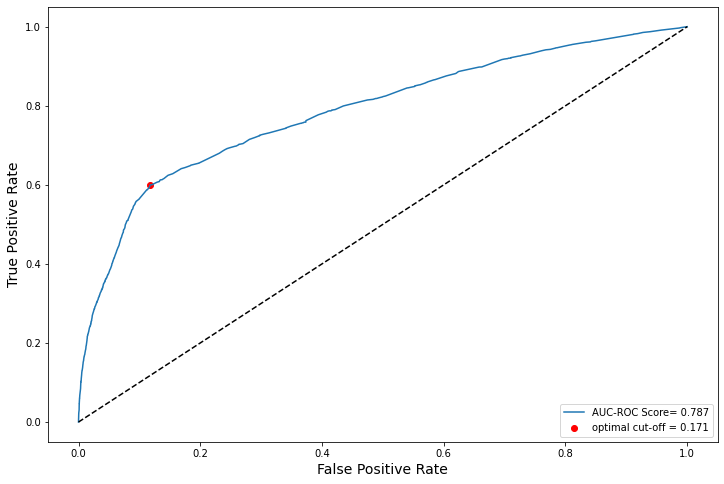

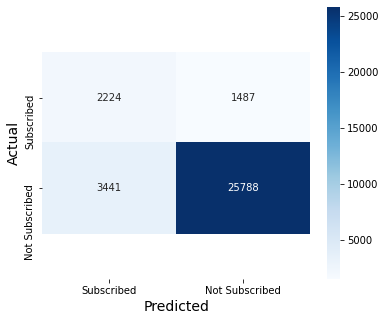

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     29229
           1       0.39      0.60      0.47      3711

    accuracy                           0.85     32940
   macro avg       0.67      0.74      0.69     32940
weighted avg       0.88      0.85      0.86     32940



In [54]:
lr_pred_df = model_eval(y_train,y_pred_prob)

## Model-2: K-Nearest Neighbors

In [55]:
knn_model=KNeighborsClassifier()

# Hyperparameters for GridSearchCV
#leaf_size = list(range(1,5))
n_neighbors = list(range(1,30))
metric = ['euclidean']
#weights = ['uniform','distance']

knn_params = {'n_neighbors':n_neighbors, 'metric':metric}
knn_optimal_model, knn_model_cv, knn_model_score = optimal_model_gridsearchCV(knn_model,knn_params,X_train,y_train,5,101)

Optimal model parameters:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='uniform')
Best parameters:{'metric': 'euclidean', 'n_neighbors': 29}

Cross-validation AUC score:
 [0.61147087 0.66676076 0.6944472  0.71181295 0.72545846 0.7343576
 0.73990364 0.74643258 0.74922545 0.75269147 0.75518877 0.75795019
 0.75939846 0.76031517 0.76048894 0.76111452 0.76227754 0.76225013
 0.76202973 0.76340869 0.76384059 0.76412795 0.76454673 0.76527537
 0.76609408 0.76622956 0.76634035 0.76659671 0.76770053]

Cross-validation AUC score Std.:
 [0.00475461 0.0031307  0.00575349 0.00455042 0.00764976 0.00748798
 0.00612035 0.00683712 0.00796075 0.00726749 0.00679341 0.00617593
 0.00662057 0.00552928 0.0059539  0.00614769 0.00703235 0.00807556
 0.00913402 0.00761776 0.0070915  0.00747992 0.00724002 0.00846266
 0.00864914 0.0075124  0.0085141  0.00813125 0.00840775]

 5-Fold Grid 

In [56]:
knn_optimal_model.fit(X_train, y_train)
knn_y_pred_prob = knn_optimal_model.predict_proba(X_train)
knn_y_pred_prob = knn_y_pred_prob[:,1]

In [57]:
#plot_auc_roc(y_train,knn_y_pred_prob)

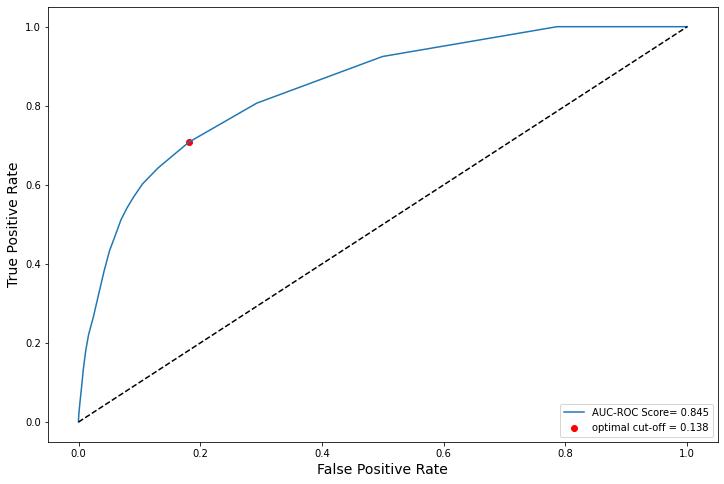

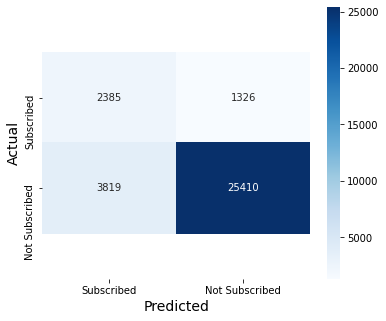

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     29229
           1       0.38      0.64      0.48      3711

    accuracy                           0.84     32940
   macro avg       0.67      0.76      0.69     32940
weighted avg       0.89      0.84      0.86     32940



In [58]:
knn_pred_df = model_eval(y_train,knn_y_pred_prob)

## Random Forest Model

In [59]:
rf_model = RandomForestClassifier()

max_depth = [i for i in range(5,16,2)]
estimators = [2,10,30,50,100]
min_samples_splits= [2,5,10,50,100,200]
rf_params={'n_estimators':estimators, 'max_depth':max_depth, 'min_samples_split':min_samples_splits,'n_jobs':[-1]}
rf_optimal_model, rf_model_cv, rf_model_score = optimal_model_gridsearchCV(rf_model,rf_params,X_train,y_train,5,151)

Optimal model parameters:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Best parameters:{'max_depth': 13, 'min_samples_split': 100, 'n_estimators': 100, 'n_jobs': -1}

Cross-validation AUC score:
 [0.77197658 0.78988787 0.7925673  0.7940877  0.79477311 0.78228415
 0.78962205 0.79375321 0.7931277  0.79368509 0.77697176 0.7908552
 0.79201956 0.79378368 0.79323072 0.78173194 0.79065751 0.7928539
 0.7937528  0.79468405 0.77471225 0.79046853 0.79196814 0.7932536
 0.79383486 0.76844755 0.78935718 0.7928

In [60]:
rf_optimal_model.fit(X_train, y_train)
rf_y_pred_prob = rf_optimal_model.predict_proba(X_train)
rf_y_pred_prob = rf_y_pred_prob[:,1]

In [61]:
#plot_auc_roc(y_train,rf_y_pred_prob)

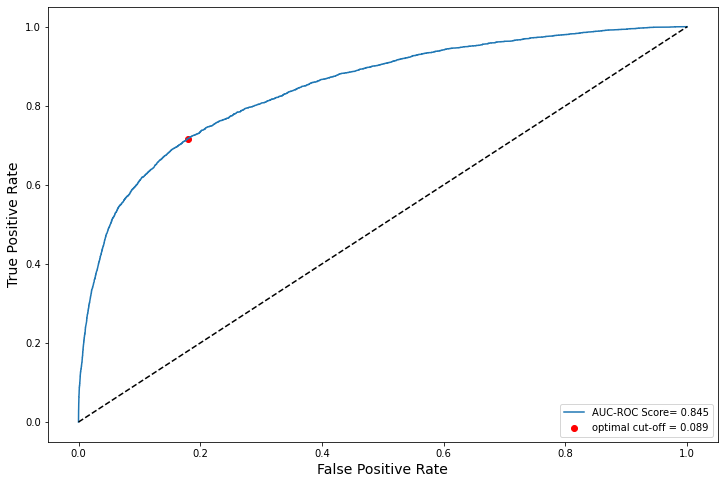

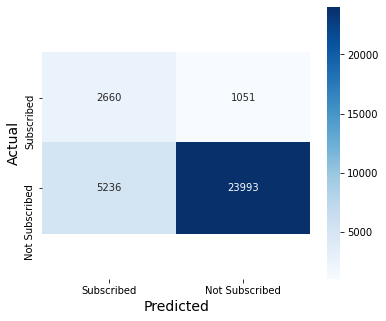

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     29229
           1       0.34      0.72      0.46      3711

    accuracy                           0.81     32940
   macro avg       0.65      0.77      0.67     32940
weighted avg       0.89      0.81      0.84     32940



In [62]:
rf_pred_df = model_eval(y_train,rf_y_pred_prob)

**Objective:**
* The main aim using these predictive models is to find out which customers are likely to subscribe the term deposit plans.
> **False Positive** are those customers, which the model thinks they have subscribed but in actual they haven't.
> **False Negative** are those customers, which the model thinks they haven't subscribed but in actual they have subscribed.
> Out of both, ***False positive*** seems more important because we can't afford to have missclassifcation for customers who we think have subscribed the term-deposit. Having so will result in failure of the marketing campaign.

* Therefore keeping that in mind, we need a model which maximize the **TPR** and at the same time keeps minimalistic **FPR**.

**Finalizing Model:**
* If we need model which gives interpretability alongside a good predictive power, **Logistic Regression** will do a fine job. Moreover, no overfitting can be seen here. But in our case, we need the best predictions at the cost of model interpretability.

* **Random Forest** is able to give best results which satisfies the above objective in comparision to **Logistic Regression** and **KNN Classifier**.

* The accuracy is **0.81** which is less compared to LR and KNN and the **precision = 0.34** which is more or less same across all 3 candidate models. But here we're concerned with a better **recall = 0.72**. The model overfits by a small extent when compared to KNN. 

### Handling Imbalanced data using SMOTE

In [63]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_bal, y_train_bal = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_bal)
print('After',counter)

Before Counter({0: 29229, 1: 3711})
After Counter({0: 29229, 1: 29229})


In [64]:
rf_model_bal = RandomForestClassifier()

max_depth = [i for i in range(5,16,2)]
estimators = [2,10,30,50,100]
min_samples_splits= [2,5,10,50,100,200]
rf_params={'n_estimators':estimators, 'max_depth':max_depth, 'min_samples_split':min_samples_splits,'n_jobs':[-1]}
rf_optimal_model_bal, rf_model_cv_bal, rf_model_score_bal = optimal_model_gridsearchCV(rf_model_bal,rf_params,X_train_bal,y_train_bal,5,121)

Optimal model parameters:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Best parameters:{'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1}

Cross-validation AUC score:
 [0.93956993 0.96335434 0.97345558 0.97868091 0.98042625 0.98169439
 0.98236222 0.98376012 0.95177765 0.9714472  0.97790057 0.98153914
 0.98253479 0.98314474 0.98380275 0.98448153 0.95963317 0.97296907
 0.97779663 0.9810437  0.98176084 0.9824368  0.9824512  0.98341044
 0.95508339 0.96701753 0.97148062 0.97384886 0.97476455 

In [65]:
rf_optimal_model_bal.fit(X_train_bal, y_train_bal)
rf_y_bal_pred_prob = rf_optimal_model_bal.predict_proba(X_train_bal)
rf_y_bal_pred_prob = rf_y_bal_pred_prob[:,1]

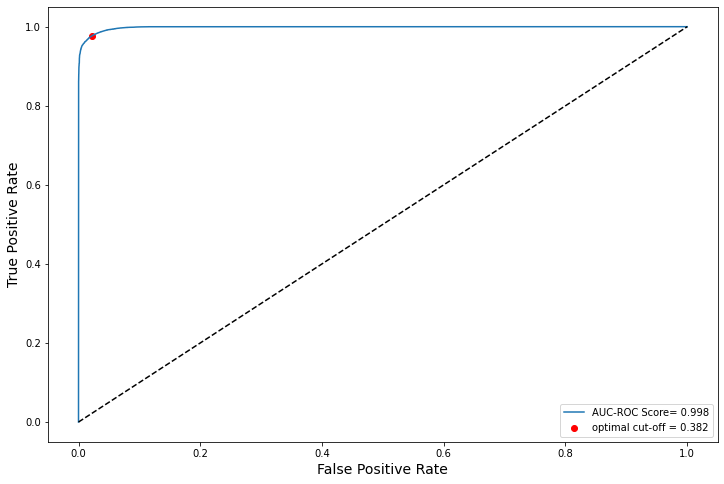

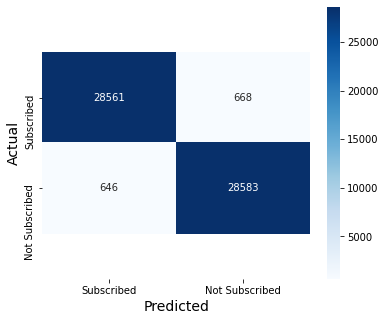

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29229
           1       0.98      0.98      0.98     29229

    accuracy                           0.98     58458
   macro avg       0.98      0.98      0.98     58458
weighted avg       0.98      0.98      0.98     58458



In [66]:
rf_bal_pred_df = model_eval(y_train_bal,rf_y_bal_pred_prob)

After oversampling the training data using SMOTE, we're able to solve the class imbalance. Doing so, we can see the model is giving the best results to us. Moreover, we can see very slight difference in AUC-ROC score for cross validation data and training data.

Therefore, this will be the final model to qualify for doing the test predictions.

### `Feature Importance`

Text(0, 0.5, 'Features')

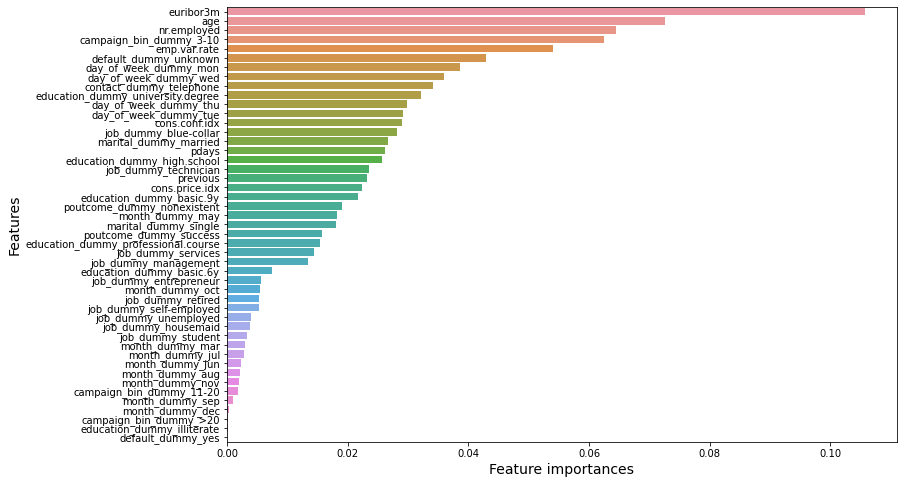

In [69]:
feature_imp_df = pd.DataFrame({'features':X_train.columns,'importance':rf_optimal_model_bal.feature_importances_})
feature_imp_df.sort_values(by='importance', ascending=False, inplace=True)

 ## Creating a bar plot for feature importance
plt.figure( figsize = ( 12, 8 ))
sns.barplot(x='importance', y='features', data=feature_imp_df);
plt.xlabel('Feature importances',fontsize=14)
plt.ylabel('Features',fontsize=14)

## Final Prediction on Test Data

In [70]:
# Define the model for testing
Final_model = rf_optimal_model_bal

# Fitting the model
Final_model.fit(X_test, y_test)

# Test predictions
final_y_pred = Final_model.predict_proba(X_test)
final_y_pred = final_y_pred[:,1]

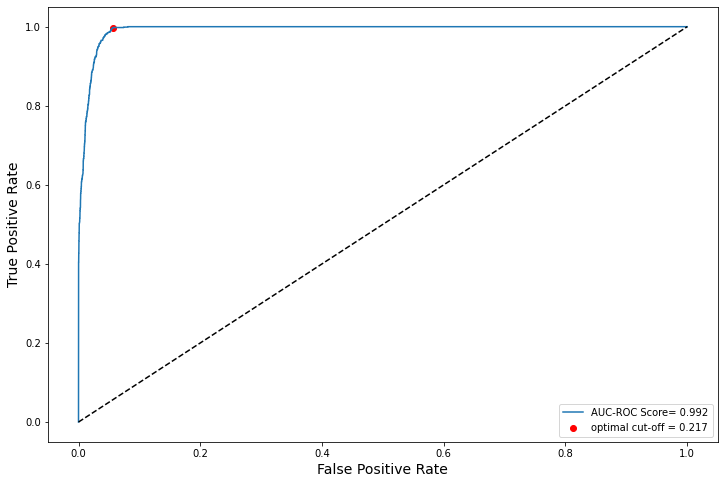

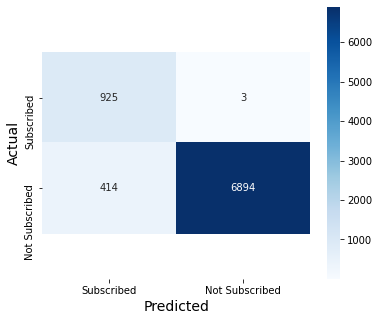

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      7308
           1       0.69      1.00      0.82       928

    accuracy                           0.95      8236
   macro avg       0.85      0.97      0.89      8236
weighted avg       0.96      0.95      0.95      8236



In [71]:
final_pred_df = model_eval(y_test,final_y_pred)

In [73]:
final_pred_df.sample(15)

,actual,predicted_prob,predicted
7073,0,0.048778,0
1689,0,0.019095,0
1485,0,0.030881,0
3093,0,0.171675,0
4857,1,0.461048,1
4357,0,0.291643,1
7088,0,0.009262,0
6698,1,0.493032,1
4215,0,0.077076,0
4507,1,0.316560,1
